# Connect To Google Drive
Steps if using Google Colab:
1. Add a shortcut of this current shared folder `Data Processing & ML Model` to your Google Drive if you haven't
2. Change Runtime to GPU (`Runtime` > `Change runtime type`)
2. Run the Cell Below

Skip if you are running local

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  path_to_file = '/content/drive/MyDrive/Data Processing & ML Model'
  print(path_to_file)

  # move to Google Drive directory
  os.chdir(path_to_file)
  !pwd

Mounted at /content/drive
/content/drive/MyDrive/Data Processing & ML Model
/content/drive/.shortcut-targets-by-id/1iOjY646e0xtJfyJHY5V3nnfVw-O7hBKy/Data Processing & ML Model


# Code

In [2]:
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

import time

# Preprocess Data
- Read x, y data
- Set day offset 
- Spill into train & test


In [3]:
# read x
full_x = torch.load('./all_x_1518.pt')
full_x = full_x / 256
x_len = full_x.size(0)

print(full_x.size())
print(full_x.type())

torch.Size([1461, 4, 290, 580])
torch.FloatTensor


In [4]:
# read y
full_y = pd.read_csv('./ACE_SWEPAM_SPEED_1518.csv', sep=',')
full_y = torch.tensor(full_y['speed']).float()
print("Full y size avail for offsetting:", full_y.size())

OFFSET = 3
full_y = full_y[OFFSET:OFFSET+x_len]
print("Full y size after offsetting:", full_y.size())


Full y size avail for offsetting: torch.Size([1466])
Full y size after offsetting: torch.Size([1461])


In [5]:
# Quick check
print(full_x.type())
print(full_x.is_contiguous())
print(full_y.type())

torch.FloatTensor
True
torch.FloatTensor


In [6]:
# train-test 80-20 split

#indices = torch.randperm(x_len)
indices = torch.arange(0, x_len) # shld not shuffle for this case
train_size = 1096
#train_size = int(x_len * 0.8)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_x = full_x[train_indices]
train_y = full_y[train_indices]
test_x  = full_x[test_indices]
test_y  = full_y[test_indices]
print(train_x.size())
print(test_x.size())

torch.Size([1096, 4, 290, 580])
torch.Size([365, 4, 290, 580])


In [7]:
train_data_size = train_x.size(0)
test_data_size = test_x.size(0)

In [8]:
# Run this cell if not enough RAM on Google Colab
del full_x
del full_y

# Develop and Train Model

TODO:
- [ ] Include Citation

### Utility Functions

In [9]:
# Utility Functions
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [10]:
def get_pearson_coeffi(pred_y, true_y):
    y1 = pred_y - torch.mean(pred_y)
    y2 = true_y - torch.mean(true_y)
    
    coeffi = torch.sum(y1 * y2) / (torch.sqrt(torch.sum(y1 ** 2)) * torch.sqrt(torch.sum(y2 ** 2)))
    return coeffi.item()

In [11]:
def eval_on_test_set():
    # for loss
    running_loss = 0
    num_batches = 0

    run_l1 = 0
    
    # for coefficient
    all_pred_y = []
    all_true_y = []

    for i in range(0,(test_data_size//bs)*bs, bs):

        minibatch_x = test_x[i:i+bs]
        minibatch_y = test_y[i:i+bs]

        minibatch_x = minibatch_x.to(device)
        minibatch_y = minibatch_y.to(device)

        inputs = (minibatch_x - mean)/std

        scores=net(inputs)
        
        loss =criterion(scores , minibatch_y) # Use RMSE
        
        all_pred_y.extend(scores.squeeze().tolist())
        all_true_y.extend(minibatch_y.squeeze().tolist())
        
        running_loss += loss.item()

        tmp_l = alt_criterion(scores, minibatch_y)
        run_l1 += tmp_l.detach().item()

        num_batches+=1


    total_loss = running_loss/num_batches
    
    all_pred_y = torch.Tensor(all_pred_y)
    all_true_y = torch.Tensor(all_true_y)
    
    coeffi = get_pearson_coeffi(all_pred_y, all_true_y)
    print( 'test loss =', total_loss, '\t test coeffi =', coeffi, "\t L1 loss =", run_l1/num_batches)

    return total_loss

### Define Model

In [29]:
# Define Model following the paper
class Convnet(nn.Module):

    def __init__(self):

        super(Convnet, self).__init__()
        
        # layer 1 : 4 * 290 * 580 -> 32 * 145 * 290
        self.conv1 = nn.Conv2d(4, 32,  kernel_size=9, padding=4, stride=3)
        self.pool1 = nn.MaxPool2d(2,2)
        
        # layer 2 : 32 * 145 * 290 -> 64 * 72 * 145
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.pool2 = nn.MaxPool2d(2,2)
        
        # layer 3 : 64 * 72 * 145 -> 128 * 24 * 48
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.pool3 = nn.MaxPool2d(3,3)
        
        # FC Layer
        self.linear1 = nn.Linear(1024, 4096) # previously tried 1024 local
        self.linear2 = nn.Linear(4096, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = x.view(-1, 1024)
        
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        
        return x

In [30]:
net = Convnet()
print(net)
display_num_param(net)

Convnet(
  (conv1): Conv2d(4, 32, kernel_size=(9, 9), stride=(3, 3), padding=(4, 4))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1, bias=True)
)
There are 4305249 (4.31 million) parameters in this neural network


### Generate Model Diagram for Visualisation

In [27]:
!pip install torchviz

In [28]:
from torchviz import make_dot

make_dot(net(test_x[0].unsqueeze(0)), params=dict(list(net.named_parameters()))).render("attached", format="png")

RuntimeError: ignored

In [ ]:
# Alternative Method
!pip install torchvision
!pip install torchsummary

In [ ]:
from torchvision import models
from torchsummary import summary

In [ ]:
summary(net, input_size=(4, 290, 580))

### Set Device
Use CUDA on Google Colab

In [31]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [32]:
mean= train_x.mean()
std = train_x.std()

In [33]:
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

### Set Hyperparameters
Use the same hyperparameters if the paper mentions it

Use RMSE for Loss

In [34]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

In [35]:
criterion = RMSELoss
optimizer=torch.optim.Adam( net.parameters() , lr=1e-5 )

alt_criterion = nn.L1Loss()

bs= 16

In [36]:
epochs = 10

### Training

In [37]:
start=time.time()

train_losses = []
val_losses = []

for epoch in range(epochs):
    # for loss
    running_loss = 0
    num_batches = 0

    run_l1 = 0
    
    # for coefficient
    all_pred_y = []
    all_true_y = []
    
    shuffled_indices=torch.randperm(train_data_size)
 
    for count in range(0, (train_data_size//bs)*bs, bs):
    
        optimizer.zero_grad()
         
        indices=shuffled_indices[count:count+bs]
        minibatch_x = train_x[indices]
        minibatch_y = train_y[indices].view(bs, 1)

        minibatch_x=minibatch_x.to(device)
        minibatch_y=minibatch_y.to(device)
        
        # normalize the minibatch
        inputs = (minibatch_x - mean)/std
        
        inputs.requires_grad_()

        scores = net(inputs) 

        loss = criterion(scores , minibatch_y) # Use RMSE
          
        loss.backward()

        optimizer.step()
        
        # START COMPUTING STATS
        running_loss += loss.detach().item()
        num_batches+=1

        tmp_l = alt_criterion(scores, minibatch_y)
        run_l1 += tmp_l.detach().item()
        
        all_pred_y.extend(scores.squeeze().tolist())
        all_true_y.extend(minibatch_y.squeeze().tolist())
    
    total_loss = running_loss/num_batches
    elapsed = time.time()-start
    
    test_err = 0
    if epoch % 1 == 0:
        
        all_pred_y = torch.Tensor(all_pred_y)
        all_true_y = torch.Tensor(all_true_y)
        coeffi = get_pearson_coeffi(all_pred_y, all_true_y)
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss, '\t coeffi=', coeffi)
        print('L1Loss=', run_l1 / num_batches)
        
        train_losses.append(total_loss)
        val_losses.append(eval_on_test_set()) 
        print()
    

epoch= 0 	 time= 0.7877049446105957 	 loss= 417.2659691704644 	 coeffi= 0.02959161251783371
L1Loss= 411.18424224853516
test loss = 411.3283216688368 	 test coeffi = -0.39035728573799133 	 L1 loss = 406.3270568847656



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch= 1 	 time= 1.5376710891723633 	 loss= 414.6268615722656 	 coeffi= -0.019868552684783936
L1Loss= 408.7433598836263
test loss = 409.8206719292535 	 test coeffi = -0.3425233066082001 	 L1 loss = 404.8015713161892

epoch= 2 	 time= 2.3078978061676025 	 loss= 413.78270043267145 	 coeffi= -0.001058058231137693
L1Loss= 407.58653683132593
test loss = 406.2115783691406 	 test coeffi = 0.053714219480752945 	 L1 loss = 401.1492682562934

epoch= 3 	 time= 3.070418119430542 	 loss= 407.863776312934 	 coeffi= -0.01771104522049427
L1Loss= 401.8348600599501
test loss = 397.4131842719184 	 test coeffi = 0.010196075774729252 	 L1 loss = 392.2422790527344

epoch= 4 	 time= 3.8105556964874268 	 loss= 394.2428444756402 	 coeffi= -0.053179338574409485
L1Loss= 387.8519982231988
test loss = 376.2023010253906 	 test coeffi = 0.17272084951400757 	 L1 loss = 370.74915907118054

epoch= 5 	 time= 4.569125413894653 	 loss= 360.6575715806749 	 coeffi= -0.025739911943674088
L1Loss= 353.8648681640625
test loss =

### Plot Training Loss Graph

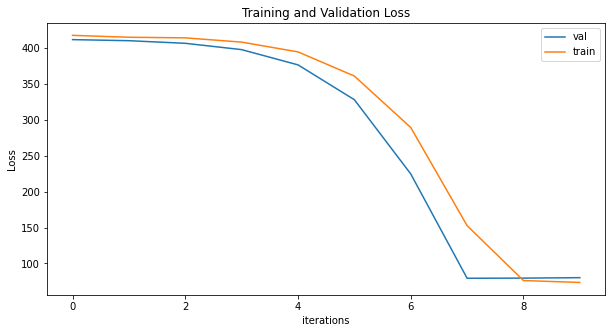

In [38]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()